<a href="https://colab.research.google.com/github/sabrinabenb/Graph-Neural-Network-GNN/blob/main/GCNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#fist install all librares

In [69]:
 #Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.4.1+cu121
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 240, in _build_one_inside_env
    wheel_path = build_wheel_legacy(
  File "/usr/local/lib/python3.1

In [70]:
from typing import Optional

import torch
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    SparseTensor,
    torch_sparse,
)
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import add_self_loops as add_self_loops_fn
from torch_geometric.utils import (
    is_torch_sparse_tensor,
    scatter,
    spmm,
    to_edge_index,
)
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils.sparse import set_sparse_value


@torch.jit._overload
def gcn_norm(  # noqa: F811
        edge_index, edge_weight, num_nodes, improved, add_self_loops, flow,
        dtype):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, str, Optional[int]) -> OptPairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(  # noqa: F811
        edge_index, edge_weight, num_nodes, improved, add_self_loops, flow,
        dtype):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, str, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_norm(  # noqa: F811
    edge_index: Adj,
    edge_weight: OptTensor = None,
    num_nodes: Optional[int] = None,
    improved: bool = False,
    add_self_loops: bool = True,
    flow: str = "source_to_target",
    dtype: Optional[torch.dtype] = None,
):
    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        assert edge_index.size(0) == edge_index.size(1)

        adj_t = edge_index

        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = torch_sparse.fill_diag(adj_t, fill_value)

        deg = torch_sparse.sum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = torch_sparse.mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = torch_sparse.mul(adj_t, deg_inv_sqrt.view(1, -1))

        return adj_t

    if is_torch_sparse_tensor(edge_index):
        assert edge_index.size(0) == edge_index.size(1)

        if edge_index.layout == torch.sparse_csc:
            raise NotImplementedError("Sparse CSC matrices are not yet "
                                      "supported in 'gcn_norm'")

        adj_t = edge_index
        if add_self_loops:
            adj_t, _ = add_self_loops_fn(adj_t, None, fill_value, num_nodes)

        edge_index, value = to_edge_index(adj_t)
        col, row = edge_index[0], edge_index[1]

        deg = scatter(value, col, 0, dim_size=num_nodes, reduce='sum')
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        value = deg_inv_sqrt[row] * value * deg_inv_sqrt[col]

        return set_sparse_value(adj_t, value), None

    assert flow in ['source_to_target', 'target_to_source']
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    if add_self_loops:
        edge_index, edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)

    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                 device=edge_index.device)

    row, col = edge_index[0], edge_index[1]
    idx = col if flow == 'source_to_target' else row
    deg = scatter(edge_weight, idx, dim=0, dim_size=num_nodes, reduce='sum')
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    return edge_index, edge_weight


class GCNConv(MessagePassing):

    _cached_edge_index: Optional[OptPairTensor]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: Optional[bool] = None,
        normalize: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        if add_self_loops is None:
            add_self_loops = normalize

        if add_self_loops and not normalize:
            raise ValueError(f"'{self.__class__.__name__}' does not support "
                             f"adding self-loops to the graph when no "
                             f"on-the-fly normalization is applied")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')

        if bias:
            self.bias = Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:

        if isinstance(x, (tuple, list)):
            raise ValueError(f"'{self.__class__.__name__}' received a tuple "
                             f"of node features as input while this layer "
                             f"does not support bipartite message passing. "
                             f"Please try other layers such as 'SAGEConv' or "
                             f"'GraphConv' instead")

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, self.flow, x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, self.flow, x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight)

        if self.bias is not None:
            out = out + self.bias

        return out


    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: Adj, x: Tensor) -> Tensor:
        return spmm(adj_t, x, reduce=self.aggr)


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import BatchNorm1d

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout=0.0):
        super().__init__()
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))

        self.norms = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.norms.append(BatchNorm1d(hidden_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
           x = F.dropout(x, p=self.dropout, training=self.training)
           x = conv(x, edge_index)
           x = x.relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
import time
model = Net(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_layers=100, dropout=0.1
)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.edge_index).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

<IPython.core.display.Javascript object>

Epoch: 0001, Loss: 1.9459 Train: 0.1429, Val: 0.1620, Test: 0.1490, Final Test: 0.1490
Epoch: 0002, Loss: 1.9452 Train: 0.1429, Val: 0.1620, Test: 0.1490, Final Test: 0.1490
Epoch: 0003, Loss: 1.9440 Train: 0.1429, Val: 0.1620, Test: 0.1490, Final Test: 0.1490
Epoch: 0004, Loss: 1.9435 Train: 0.1429, Val: 0.1220, Test: 0.1300, Final Test: 0.1490
Epoch: 0005, Loss: 1.9429 Train: 0.1429, Val: 0.1220, Test: 0.1300, Final Test: 0.1490
Epoch: 0006, Loss: 1.9426 Train: 0.1429, Val: 0.1220, Test: 0.1300, Final Test: 0.1490
Epoch: 0007, Loss: 1.9420 Train: 0.1429, Val: 0.1220, Test: 0.1300, Final Test: 0.1490
Epoch: 0008, Loss: 1.9427 Train: 0.1571, Val: 0.1260, Test: 0.1290, Final Test: 0.1490
Epoch: 0009, Loss: 1.9411 Train: 0.1500, Val: 0.1180, Test: 0.1370, Final Test: 0.1490
Epoch: 0010, Loss: 1.9406 Train: 0.1500, Val: 0.1060, Test: 0.1220, Final Test: 0.1490
Epoch: 0011, Loss: 1.9405 Train: 0.1500, Val: 0.1100, Test: 0.1210, Final Test: 0.1490
Epoch: 0012, Loss: 1.9396 Train: 0.1429, Va

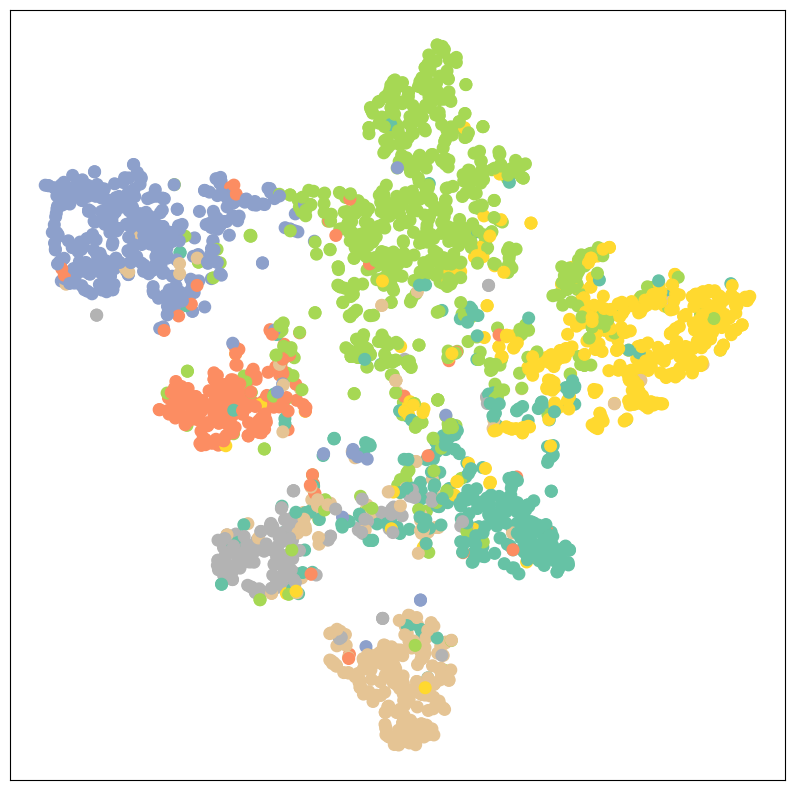

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)